# Testing Notebook

This notebook provides some test code/ experimentation for the implementation of centrality analysis from the paper *On the Concept of Depth from Functional Data*

Warning: the work here is very rough.

The following function produces all subsequences of length `l` from the list `s`. 

In [1]:
from itertools import combinations 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def subsequences(s, l):
    '''Returns a list of all possible subsequences of the given length from the given input list
    Parameters:
    -------------
    s: List to enumerate
    l: length of subsequences to find'''
    return sorted(set([i for i in combinations(s, l)]))

We now test the standard definition of $V(x_{i_1}, ... ,x_{i_j})$ containment in $\mathbb{R}^2$ 

And define a fake dataset to do so

In [2]:
df = pd.DataFrame([
    [1, 2, 3, 6, 9],
    [2, 4, 4, 7, 9],
    [3, 5, 4, 6.5, 12],
    [2, 6, 2, 6, 11],
    [1, 2, 1, 7, 11],
], columns=list('12345'))

df

,1,2,3,4,5
0,1,2,3,6.0,9
1,2,4,4,7.0,9
2,3,5,4,6.5,12
3,2,6,2,6.0,11
4,1,2,1,7.0,11


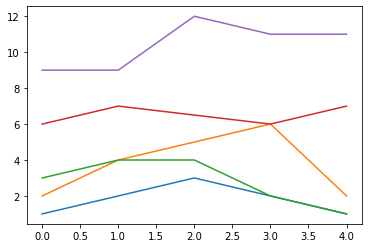

In [3]:
plt.plot(df);

In [118]:
from statdepth.depth import banddepth

# banddepth([df], containment='r2', J=2)

We now test the closed form solution

In [4]:
from scipy.special import comb, binom

def banddepthclosed(data: pd.DataFrame, method='MBD'):
    n, p = data.shape
    rv = np.argsort(data, axis=0)
    rmat = np.argsort(rv, axis=0) + 1

    # This code is an explicit solution for J=2 and therefore cannot be generalized. 
    # band depth
    def _fbd2():
        down = np.min(rmat, axis=1) - 1
        up = n - np.max(rmat, axis=1)
        return (up * down + n - 1) / comb(n, 2)

    # modified band depth
    def _fmbd():
        down = rmat - 1
        up = n - rmat
        return ((np.sum(up * down, axis=1) / p) + n - 1) / comb(n, 2)

    if method == 'BD2':
        depth = _fbd2()
    elif method == 'MBD':
        depth = _fmbd()
    else:
        raise ValueError("Unknown input value for parameter `method`.")

    return depth

banddepthclosed(df)

0    0.48
1    0.74
2    0.54
3    0.66
4    0.58
dtype: float64

We now redefine our band depth to use a modified definition for containment

In [120]:
def _r2_containment(data: pd.DataFrame, curve: pd.Series, relax: bool) -> float:
    # Generate discrete band 
    containment = 0
    
    y_range = []
    
    mins = data.min(axis=1)
    maxs = data.max(axis=1)
    
    intervals = [[i, j] for i, j in zip(mins, maxs)]
    
    # Check if each value in the curve is entirely contained within the band 
    for index, val in enumerate(curve):
        # If any value is not, then break out. This is strict containment!
        if intervals[index][0] <= val <= intervals[index][1]:
            containment += 1
        
    return containment / len(curve) if relax else containment // len(curve)

In [133]:
def _band_depth(data: pd.DataFrame, curve: str, relax: bool, containment='r2', J=2) -> float:    
    # Initialize band depth, n (number of curves)
    band_depth = 0
    n = data.shape[1]
    
    # Select our containment definition if it is in our pre-defined list
    if containment == 'r2':
        cdef = _r2_containment
    elif containment == 'r2_enum':
        cdef = _r2_enum_containment
    elif containment == 'simplex':
        cdef = _simplex_containment
    else:
        # TODO: Allow user to pass in custom definition of containment
        raise ValueError('Error: Unknown or unspecified definition of containment')

    # Grab the data for our curve so numerical slicing is guaranteed to work
    curve_data = data.loc[:, curve]

    # Drop the curve (we don't want it used in defining our band/generalized band -- doesn't make sense)
    data = data.drop(curve, axis=1)

    # Define our index to be the columns of our dataset, excluding the last row (for indexing reasons)
    idx = list(data.columns)
    
    # Compute band depth
    for j in range(2, J + 1):
        
        # Initialize S_n^(j) as defined in the paper
        S_nj = 0

        # Get a list of all possible subsequences of samples (cols)
        subseq = subsequences(idx, j)

        # Get generalized containment for this value of J=j
        for sequence in subseq:
            subseq_df = data.loc[:, list(sequence)]

            S_nj += cdef(data=subseq_df, curve=curve_data, relax=relax)

        band_depth += S_nj / binom(n, j)
    
    return band_depth

def banddepth(data: list, J=2, containment='r2', relax=False):
    # If only one item in the list, it is the real-valued case
    
    if len(data) == 1:
        band_depths = []
        df = data[0]
        for col in df.columns:
            band_depths.append(_band_depth(data=df, curve=col, containment=containment, J=J, relax=relax))
        return pd.Series(index=df.columns, data=band_depths)
    else: 
        pass
    
    return None

In [138]:
df

,1,2,3,4,5
0,1,2,3,6.0,9
1,2,4,4,7.0,9
2,3,5,4,6.5,12
3,2,6,2,6.0,11
4,1,2,1,7.0,11


In [137]:
banddepth(data=[df], J=2, relax=True)

1    0.12
2    0.42
3    0.36
4    0.34
5    0.00
dtype: float64

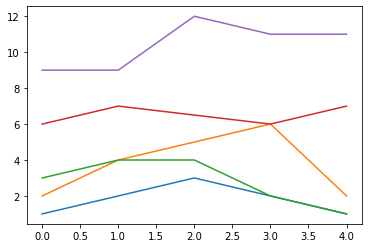

In [102]:
plt.plot(df);

In [132]:
banddepthclosed(df)

0    0.48
1    0.74
2    0.54
3    0.66
4    0.58
dtype: float64

In [139]:
df = pd.DataFrame({'x_0': [1, 2, 1, 1, 2], 
                    'x_1': [2, 3, 4, 2, 2], 
                    'x_2': [1, 3, 1, 3, 2],
                    'x_3': [1, 2, 1, 1, 2],
                    'x_4': [2, 3, 4, 2, 1]}, 
                   index=['f_1', 'f_2', 'f_3', 'f_4', 'f_5'])

In [164]:
df = pd.DataFrame(np.random.randint(0,101,size=(137, 4)), columns=list('ABCD'))
df

,A,B,C,D
0,29,72,45,25
1,71,17,97,36
2,55,48,2,1
3,79,35,23,74
4,74,73,92,22
...,...,...,...,...
132,93,69,17,2
133,60,61,48,39
134,57,34,75,72
135,62,52,69,95


In [235]:
from typing import Callable 

def _r2_containment(data: pd.DataFrame, curve: pd.Series, relax: bool) -> float:
    containment = 0
    
    y_range = []
    
    mins = data.min(axis=1)
    maxs = data.max(axis=1)
    
    intervals = [[i, j] for i, j in zip(mins, maxs)]
    
    # Check if each value in the curve is entirely contained within the band 
    for index, val in enumerate(curve):
        # If any value is not, then break out. This is strict containment!
        if intervals[index][0] <= val <= intervals[index][1]:
            containment += 1
        
    return containment / len(curve) if relax else containment // len(curve)

def _univariate_band_depth(data: pd.DataFrame, curve: int, relax: bool, containment: Callable, J=2) -> float:
    
    # Initialize band depth, n (number of curves)
    band_depth = 0
    n = data.shape[1]
    
    # Grab the data for our curve so numerical slicing is guaranteed to work
    curve_data = data.loc[:, curve]

    # Drop the curve (we don't want it used in defining our band/generalized band -- doesn't make sense)
    data = data.drop(curve, axis=1)

    # Define our index to be the columns of our dataset, excluding the last row (for indexing reasons)
    idx = list(data.columns)
    
    # Compute band depth
    for j in range(2, J + 1):
        
        # Initialize S_n^(j) as defined in the paper
        S_nj = 0

        # Get a list of all possible subsequences of samples (cols)
        subseq = subsequences(idx, j)

        # Get generalized containment for this value of J=j
        for sequence in subseq:
            subseq_df = data.loc[:, list(sequence)]
            S_nj += containment(data=subseq_df, curve=curve_data, relax=relax)

        band_depth += S_nj / binom(n, j)
    
    return band_depth

def banddepth(data: List[pd.DataFrame], J=2, containment='r2', relax=False, deep_check=False):
    # Select containment definition
    cdef = _r2_containment

    # If only one item in the list, it is the real-valued case
    if len(data) == 1:
        band_depths = []
        df = data[0]
        for col in df.columns:
            band_depths.append(_univariate_band_depth(data=df, curve=col, relax=relax, containment=cdef, J=J))
        return band_depths
    else: 
        # Multivariate case
        pass
    
    return None


In [268]:
from typing import List 
import random

def samplebanddepth(data: List[pd.DataFrame], K: int, J=2, containment='r2', relax=False, deep_check=False):

    band_depth_samples = []

    # Handle common errros
#     _handle_depth_errors(data=data, J=J, deep_check=deep_check)

    cdef = _r2_containment
    
    # Univariate case
    if len(data) == 1:
        df = data[0]
        ss = df.shape[0] // K
        for _ in range(K):
            t = df.sample(n=ss)
            df = df.drop(t.index)
            band_depth_samples.append((banddepth(data=[t], J=J, containment=containment, relax=relax, deep_check=deep_check)))
    else:
        # Multivariate case: partition list of DataFrames randomly, compute band depth w.r.t those
        shuffled = data.copy()
        random.shuffle(shuffled)
        ss = len(data) // K 

        for _ in range(K ):
            pass
        

    return (band_depth_samples)


In [269]:
samples = samplebanddepth([df], K=2, relax=True)

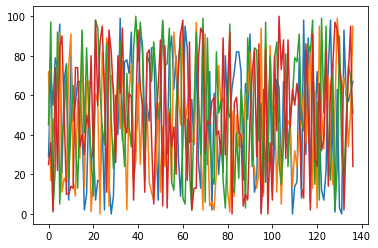

In [270]:
plt.plot(df);

In [271]:
samples

[[0.14215686274509806,
  0.22058823529411764,
  0.16666666666666666,
  0.14705882352941177],
 [0.17156862745098042,
  0.17401960784313728,
  0.17647058823529413,
  0.1593137254901961]]

In [263]:
K=2
depths = []

for k in range(df.shape[1]):
    t = [samples[i][k] for i in range(K)]
    depths.append(np.mean(t))
    
depths

[0.1568627450980392,
 0.19730392156862747,
 0.1715686274509804,
 0.1531862745098039]

In [267]:
banddepth([df], relax=True)

[0.15571776155717762,
 0.19829683698296838,
 0.17031630170316303,
 0.15450121654501217]

In [274]:
!pip install ..

Processing /Users/julian/Documents/Projects/statdepth
  Created wheel for statdepth: filename=statdepth-0.1.0-py2.py3-none-any.whl size=10138 sha256=b02c42af29931f9d33725b74a8f95743f8b72bd9933a1275ed9bdda299883dd8
  Stored in directory: /private/var/folders/pd/jsjcl0fn7w57s5mfr34b20pm0000gn/T/pip-ephem-wheel-cache-zni5stht/wheels/94/78/65/e7cb177a6619a78b187853c88271a8abc224aa673b05e4ed56
Successfully built statdepth
  Attempting uninstall: statdepth
    Found existing installation: statdepth 0.1.0
    Uninstalling statdepth-0.1.0:
      Successfully uninstalled statdepth-0.1.0


In [275]:
from statdepth.depth import banddepth, samplebanddepth

ImportError: cannot import name 'samplebanddepth' from 'statdepth.depth' (/Users/julian/opt/miniconda3/envs/base-data-science/lib/python3.8/site-packages/statdepth/depth/__init__.py)